In [21]:
!pip install "gymnasium==0.29.1" -q
!pip install myosuite -q

In [107]:
from IPython.display import HTML
from myosuite.logger.grouped_datasets import Trace
import matplotlib.pyplot as plt
from base64 import b64encode
import scipy.sparse as spa
from copy import deepcopy
from tqdm import tqdm
import pandas as pd
import math
# import gym
from myosuite.utils import gym

# from dm_control import mujoco
# from dm_control.mujoco.wrapper import mjbindings

import myosuite
import numpy as np
import skvideo.io
import mujoco
import osqp
import os

import logging

# Show everything
logging.getLogger().setLevel(logging.DEBUG)

In [ ]:
# Download the model from Myolab
"""
Model is from Myolab and not MyoHub. Thus can't use Test Sim loader. Ask community if I have to move them
"""
!git clone https://github.com/MyoHub/myosuite ./content

# Clone into a specific folder
!git clone https://github.com/MyoHub/myo_sim.git ./content/myosuite/myosuite/simhive/myo_sim
%cd ./content/myosuite/myosuite/simhive/myo_sim
!git checkout 33f3ded946f55adbdcf963c99999587aadaf975f

fatal: destination path 'myosuite' already exists and is not an empty directory.
Cloning into '/content/myosuite/myosuite/simhive/myo_sim'...
remote: Enumerating objects: 1646, done.
remote: Counting objects: 100% (556/556), done.
remote: Compressing objects: 100% (207/207), done.
remote: Total 1646 (delta 433), reused 357 (delta 349), pack-reused 1090 (from 2)
Receiving objects: 100% (1646/1646), 87.70 MiB | 24.77 MiB/s, done.
Resolving deltas: 100% (848/848), done.
/content/myosuite/myosuite/simhive/myo_sim
Note: switching to '33f3ded946f55adbdcf963c99999587aadaf975f'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:


In [ ]:
# Load trajectory h5 file --- Upload csv from local system
!mkdir -p data
!wget -O data/trace_resized_trimmed_test_2_compressed.h5 https://github.com/SiddheshKanawade/myosuite-table-tennis/blob/master/trajectory/trace_resized_trimmed_test_2_compressed.h5

--2025-08-31 12:12:38--  https://github.com/SiddheshKanawade/myosuite-table-tennis/blob/master/trajectory/trace_resized_trimmed_test_2_compressed.h5
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘data/trace_resized_trimmed_test_2_compressed.h5’

data/trace_resized_     [ <=>                ] 181.81K  --.-KB/s    in 0.05s   

2025-08-31 12:12:39 (3.56 MB/s) - ‘data/trace_resized_trimmed_test_2_compressed.h5’ saved [186176]



In [ ]:
model_path = "./content/myosuite/myosuite/envs/myo/assets/arm/myoarm_tabletennis.xml"

# Utils

In [195]:
# Load model
def get_sim(model_path):
  return mujoco.MjModel.from_xml_path(model_path)

def show_video(video_path, video_width = 400):
    """
    Display a video within the notebook.
    """
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video autoplay width={video_width} controls><source src="{video_url}"></video>""")

def solve_qp(P, q, lb, ub, x0):
    """
    Solve a quadratic program.
    """
    P = spa.csc_matrix(P)
    A = spa.csc_matrix(spa.eye(q.shape[0]))
    m = osqp.OSQP()
    m.setup(P=P, q=q, A=A, l=lb, u=ub, verbose=False)
    m.warm_start(x=x0)
    res = m.solve()
    return res.x

def plot_qxxx(qxxx, joint_names, labels):
    """
    Plot generalized variables to be compared.
    qxxx[:,0,-1] = time axis
    qxxx[:,1:,n] = n-th sequence
    qxxx[:,1:,-1] = reference sequence
    """
    fig, axs = plt.subplots(4, 6, figsize=(12, 8))
    axs = axs.flatten()
    line_objects = []
    linestyle = ['-'] * qxxx.shape[2]
    linestyle[-1] = '--'
    for j in range(1, len(joint_names)+1):
        ax = axs[j-1]
        for i in range(qxxx.shape[2]):
            line, = ax.plot(qxxx[:, 0, -1], qxxx[:, j, i], linestyle[i])
            if j == 1: # add only one set of lines to the legend
                line_objects.append(line)
        ax.set_xlim([qxxx[:, 0].min(), qxxx[:, 0].max()])
        ax.set_ylim([qxxx[:, 1:, :].min(), qxxx[:, 1:, :].max()])
        ax.set_title(joint_names[j-1])
    legend_ax = axs[len(joint_names)] # create legend in the 24th subplot area
    legend_ax.axis('off')
    legend_ax.legend(line_objects, labels, loc='center')
    plt.tight_layout()
    plt.show()

def plot_qxxx(qxxx, joint_names, labels, lw=20):
    """
    Plot joint variables to be compared.
    qxxx[:,0,-1] = time axis
    qxxx[:,1:,n] = n-th sequence
    """
    n_joints = len(joint_names)
    ncols = 6
    nrows = math.ceil((n_joints + 1) / ncols)  # +1 for legend subplot

    fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
    axs = axs.flatten()

    line_objects = []
    linestyle = ['-'] * qxxx.shape[2]
    linestyle[-1] = '--'

    for j in range(1, n_joints+1):
        ax = axs[j-1]
        for i in range(qxxx.shape[2]):
            line, = ax.plot(
                qxxx[:, 0, -1],
                qxxx[:, j, i],
                linestyle[i],
                linewidth=lw
            )
            if j == 1:  # add only one set of lines to the legend
                line_objects.append(line)
        ax.set_xlim([qxxx[:, 0].min(), qxxx[:, 0].max()])
        ax.set_ylim([qxxx[:, 1:, :].min(), qxxx[:, 1:, :].max()])
        ax.set_title(joint_names[j-1])

    # legend in last subplot
    legend_ax = axs[n_joints]
    legend_ax.axis('off')
    legend_ax.legend(line_objects, labels, loc='center')

    plt.tight_layout()
    plt.show()

# Preprocess Trajectory

In [ ]:
inverse_name_map = {
    "Abs_t2": "Abs_t2",
    "Abs_t1": "Abs_t1",
    "Abs_r3": "Abs_r3",
    "pro_sup": "pro_sup",
    "deviation": "deviation",
    # Spine
    "L5_S1_Flex_Ext": "flex_extension",
    "L5_S1_Lat_Bending": "lat_bending",
    "L5_S1_axial_rotation": "axial_rotation",
    "L4_L5_Flex_Ext": "L4_L5_FE",
    "L4_L5_Lat_Bending": "L4_L5_LB",
    "L4_L5_axial_rotation": "L4_L5_AR",
    "L3_L4_Flex_Ext": "L3_L4_FE",
    "L3_L4_Lat_Bending": "L3_L4_LB",
    "L3_L4_axial_rotation": "L3_L4_AR",
    "L2_L3_Flex_Ext": "L2_L3_FE",
    "L2_L3_Lat_Bending": "L2_L3_LB",
    "L2_L3_axial_rotation": "L2_L3_AR",
    "L1_L2_Flex_Ext": "L1_L2_FE",
    "L1_L2_Lat_Bending": "L1_L2_LB",
    "L1_L2_axial_rotation": "L1_L2_AR",
    # # Clavicle / scapula
    "sternoclavicular_r2_r": "sternoclavicular_r2",
    "sternoclavicular_r3_r": "sternoclavicular_r3",
    "unrotscap_r3_r": "unrotscap_r3",
    "unrotscap_r2_r": "unrotscap_r2",
    "acromioclavicular_r2_r": "acromioclavicular_r2",
    "acromioclavicular_r3_r": "acromioclavicular_r3",
    "acromioclavicular_r1_r": "acromioclavicular_r1",
    # # Humerus / arm
    "unrothum_r1_r": "unrothum_r1",
    "unrothum_r3_r": "unrothum_r3",
    "unrothum_r2_r": "unrothum_r2",
    "elv_angle_r": "elv_angle",
    "shoulder_elv_r": "shoulder_elv",
    "shoulder1_r2_r": "shoulder1_r2",
    "shoulder_rot_r": "shoulder_rot",
    "elbow_flex_r": "elbow_flexion",
    # # Wrist & thumb
    "flexion_r": "flexion",
    "cmc_abduction_r": "cmc_abduction",
    "cmc_flexion_r": "cmc_flexion",
    "mp_flexion_r": "mp_flexion",
    "ip_flexion_r": "ip_flexion",
    # # Fingers
    "mcp2_flexion_r": "mcp2_flexion",
    "mcp2_abduction_r": "mcp2_abduction",
    "pm2_flexion_r": "pm2_flexion",
    "md2_flexion_r": "md2_flexion",
    "mcp3_flexion_r": "mcp3_flexion",
    "mcp3_abduction_r": "mcp3_abduction",
    "pm3_flexion_r": "pm3_flexion",
    "md3_flexion_r": "md3_flexion",
    "mcp4_flexion_r": "mcp4_flexion",
    "mcp4_abduction_r": "mcp4_abduction",
    "pm4_flexion_r": "pm4_flexion",
    "md4_flexion_r": "md4_flexion",
    "mcp5_flexion_r": "mcp5_flexion",
    "mcp5_abduction_r": "mcp5_abduction",
    "pm5_flexion_r": "pm5_flexion",
    "md5_flexion_r": "md5_flexion",
    # # Freejoints
    # "paddle_freejoint": "paddle_freejoint",
    # "pingpong_freejoint": "pingpong_freejoint",
}



def get_trajectory_data():
  H5_FILE = "./content/data/trace_resized_trimmed_test_2_compressed.h5"
  h5trajectory = Trace.load(H5_FILE)

  motion_name = list(h5trajectory.trace.keys())[0]

  timesteps = np.array(h5trajectory[motion_name]["time"])
  horizon = timesteps.shape[0]

  joint_dict = h5trajectory[motion_name]["qpos"]
  data_root = h5trajectory[motion_name]["qpos"]["myoskeleton_root"]

  data = {
      joint: np.array(values).reshape(horizon, -1)
      for joint, values in joint_dict.items()
      # if joint != "myoskeleton_root"
  }

  # data['myoskeleton_root'] = data['myoskeleton_root'].reshape(horizon,-1)
  data['mtp_angle_l'] = data['mtp_flex_l']
  data['mtp_angle_r'] = data['mtp_flex_r']

  for inv_jnt_name in inverse_name_map.keys():
    data[inverse_name_map[inv_jnt_name]] = data[inv_jnt_name]
    if inv_jnt_name != inverse_name_map[inv_jnt_name]:
      del data[inv_jnt_name]

  return data, horizon


def build_qpos_in_model_order(model, trajectory_data, steps):
  """
  Rearrange trajectory_data (dict of joint_name -> (steps, dof) arrays)
  into a (steps, nq) array matching MuJoCo's qpos order.
  """
  nq = model.nq
  trajectory = np.zeros((steps, nq))

  for j in range(model.njnt):
      jnt_name = model.joint(j).name
      qpos_addr = model.jnt_qposadr[j]   # starting index in qpos
      jtype = model.jnt_type[j]


      # dimension of this joint in qpos
      if jtype == 0:   # free
          dim = 7
      elif jtype == 1: # ball
          dim = 4
      else:            # hinge/slide
          dim = 1

      if jnt_name not in trajectory_data.keys():
        print(f"Joint: {jnt_name} not present. Initialise with zero value")
        # Initialise joint with zero value
        trajectory_data[jnt_name] = np.zeros(dim)
        continue

      vals = trajectory_data[jnt_name]   # shape (steps, dim)
      trajectory[:, qpos_addr:qpos_addr+dim] = vals

  return trajectory


# Compute qrfc

In [197]:
def reference_kinematics_from_qpos(model, qpos_ref, dt):
    """Compute qvel_ref (steps, nv) and qacc_ref (steps, nv) from qpos_ref."""
    T = qpos_ref.shape[0] # Number of steps
    nv = model.nv # number of degrees of freedom

    qvel_ref = np.zeros((T, nv))
    for i in range(T-1):
        mujoco.mj_differentiatePos(model, qvel_ref[i], dt, qpos_ref[i+1], qpos_ref[i]) # Returns velocity qvel_ref[i] required to move from qpos_ref[i+1] to qpos_ref[i] in dt
        # qvel_ref[i] = differentiate_pos_dm(model, qpos_ref[i+1], qpos_ref[i], dt)
    qvel_ref[-1] = qvel_ref[-2]  # pad last - Introduce slight error. Reduced as number of steps increases

    qacc_ref = np.zeros((T, nv))
    for i in range(1, T):
        qacc_ref[i] = (qvel_ref[i] - qvel_ref[i-1]) / dt
    qacc_ref[0] = qacc_ref[1]  # pad first - Introduce slight error. Reduced as number of steps increases
    return qvel_ref, qacc_ref

def get_qfrc(model, data, ref_qpos, ref_qvel, ref_qacc):
    """
    Compute the generalized force needed to reach the target position in the next mujoco step.
    """
    data_copy = deepcopy(data)
    data_copy.qpos = ref_qpos
    data_copy.qvel = ref_qvel
    data_copy.qacc = ref_qacc

    old_flags = model.opt.disableflags
    model.opt.disableflags |= mujoco.mjtDisableBit.mjDSBL_CONSTRAINT # Constraints = contacts, joint limits, etc

    mujoco.mj_forward(model, data_copy)   # compute bias, gains, etc
    mujoco.mj_inverse(model, data_copy)   # compute inverse dynamics

    model.opt.disableflags = old_flags # Enable contraints
    return data_copy.qfrc_inverse

# Compute Control

In [201]:
def compute_tau(model, data, act_type="rise"):
  """
  Actuators = muscles, motors, general, etc
  tau_A/D = activation rise and activation decay
  activation is only applicable for muscles
  In case of non muscle activators, keep tau as 0
  """
  tau = np.zeros(model.nu, dtype=np.float64)
  for i in range(model.nu):
    actnum = model.actuator_actnum[i]   # number of activation states for actuator i (usually 0 or 1). Muscle 1, motor 0
    if actnum > 0:
        a = model.actuator_actadr[i] # starting index into data.act where that actuator’s activation state lives.
        act_i = float(data.act[a])
        if act_type=="rise":
          tau_base = model.actuator_dynprm[i, 0]
          tau[i] = tau_base * (0.5 + 1.5 * act_i)
        elif act_type=="decay":
          tau_base = model.actuator_dynprm[i, 1]
          tau[i] = tau_base / (0.5 + 1.5 * act_i)
    else:
        # print(i)
        tau[i] = 0.0   # No activation state → tau = 0
  return tau

def map_activation_states_to_actuators(model, data):
  act_full = np.zeros(model.nu, dtype=np.float64)

  for i in range(model.nu):
      actnum = model.actuator_actnum[i]   # 0 or 1
      if actnum > 0:
          adr = model.actuator_actadr[i]  # index into data.act
          act_full[i] = data.act[adr]
      else:
          act_full[i] = 0.0   # stateless actuator → no activation
  return act_full

def get_ctrl(model, data, qpos_ref, qvel_ref, qacc_ref, qfrc, qfrc_scaler, qvel_scaler):
  """
  Compute the control needed to reach the target position in the next mujoco step.
  qfrc: generalized force resulting from inverse dynamics.
  """
  act = data.act # shape = model.na = number of activation states
  ctrl0 = data.ctrl
  ts = model.opt.timestep
  tA = compute_tau(model, data, "rise")
  tD = compute_tau(model, data, "decay")
  tausmooth = model.actuator_dynprm[:,2]
  t1 = (tA - tD) * 1.875 / tausmooth
  t2 = (tA + tD) * 0.5
  # ---- gain, bias, and moment computation
  data_copy = deepcopy(data)
  data_copy.qpos = qpos_ref
  data_copy.qvel = qvel_ref / qvel_scaler
  data_copy.qacc = qacc_ref

  mujoco.mj_step1(model, data_copy) # gain, bias, and moment depend on qpos and qvel

  gain = np.zeros(model.nu)
  bias = np.zeros(model.nu)
  for idx_actuator in range(model.nu):
      length = data_copy.actuator_length[idx_actuator]
      lengthrange = model.actuator_lengthrange[idx_actuator]
      velocity = data_copy.actuator_velocity[idx_actuator]
      acc0 = model.actuator_acc0[idx_actuator]
      prmb = model.actuator_biasprm[idx_actuator,:9]
      prmg = model.actuator_gainprm[idx_actuator,:9]
      bias[idx_actuator] = mujoco.mju_muscleBias(length, lengthrange, acc0, prmb)
      gain[idx_actuator] = min(-1, mujoco.mju_muscleGain(length, velocity, lengthrange, acc0, prmg))

  # Compute actuator_moment. data_copy.actuator_moment is sparse.
  # https://github.com/google-deepmind/mujoco/blob/5d598a49a20b73deeb6e6b55b7adf2593ea3b3f6/python/LQR.ipynb#L494
  AM = np.zeros((model.nu, model.nv))
  mujoco.mju_sparse2dense(
      AM,
      data_copy.actuator_moment.reshape(-1),
      data_copy.moment_rownnz,
      data_copy.moment_rowadr,
      data_copy.moment_colind.reshape(-1),
  )
  AM = AM.T

  # ---- ctrl computation
  P = 2 * AM.T @ AM
  act = map_activation_states_to_actuators(model, data)
  k = AM @ (gain * act) + AM @ bias - (qfrc / qfrc_scaler)
  q = 2 * k @ AM
  lb = gain * (1 - act) * ts / (t2 + t1 * (1 - act))
  ub = - gain * act * ts / (t2 - t1 * act)
  x0 = (gain * (ctrl0 - act) * ts) / ((ctrl0 - act) * t1 + t2)
  x = solve_qp(P, q, lb, ub, x0)
  ctrl = act + x * t2 / (gain * ts - x * t1)
  return np.clip(ctrl,0,1)

In [205]:
model1 = mujoco.MjModel.from_xml_path(model_path)
tausmooth = 5
model1.actuator_dynprm[:,2] = tausmooth # Tausmooth is set to 5
data1 = mujoco.MjData(model1)
data1.qpos.shape, data1.qvel.shape, data1.qacc.shape

((100,), (98,), (98,))

In [ ]:
# --- build the reference trajectory in *model order* ---
trajectory_data, horizon = get_trajectory_data()
qpos_ref = build_qpos_in_model_order(model1, trajectory_data, horizon)

assert qpos_ref.shape[1] == data1.qpos.shape[0], "Shape mismatch for qpos"

dt = model1.opt.timestep
qvel_ref, qacc_ref = reference_kinematics_from_qpos(model1, qpos_ref, dt)

qpos_ref.shape, qvel_ref.shape, qacc_ref.shape

In [207]:
all_ctrl = np.zeros((qpos_ref.shape[0], 1+model1.nu)) # model.nu = number of actuators in the model
for idx in tqdm(range(qpos_ref.shape[0])):
    target_qpos = qpos_ref[idx]
    qfrc = get_qfrc(model1, data1, qpos_ref[idx], qvel_ref[idx], qacc_ref[idx])
    ctrl = get_ctrl(model1, data1, qpos_ref[idx], qvel_ref[idx], qacc_ref[idx], qfrc, 100, 5)
    data1.ctrl = ctrl
    mujoco.mj_step(model1, data1)
    all_ctrl[idx,:] = np.hstack((data1.time, ctrl))

  0%|          | 0/300 [00:00<?, ?it/s]/tmp/ipython-input-1333062166.py:87: RuntimeWarning: divide by zero encountered in divide
  lb = gain * (1 - act) * ts / (t2 + t1 * (1 - act))
/tmp/ipython-input-1333062166.py:88: RuntimeWarning: invalid value encountered in divide
  ub = - gain * act * ts / (t2 - t1 * act)
/tmp/ipython-input-1333062166.py:89: RuntimeWarning: invalid value encountered in divide
  x0 = (gain * (ctrl0 - act) * ts) / ((ctrl0 - act) * t1 + t2)
100%|██████████| 300/300 [03:30<00:00,  1.43it/s]


qvel scaler: 1 - error max (rad): 3.2400000000000078


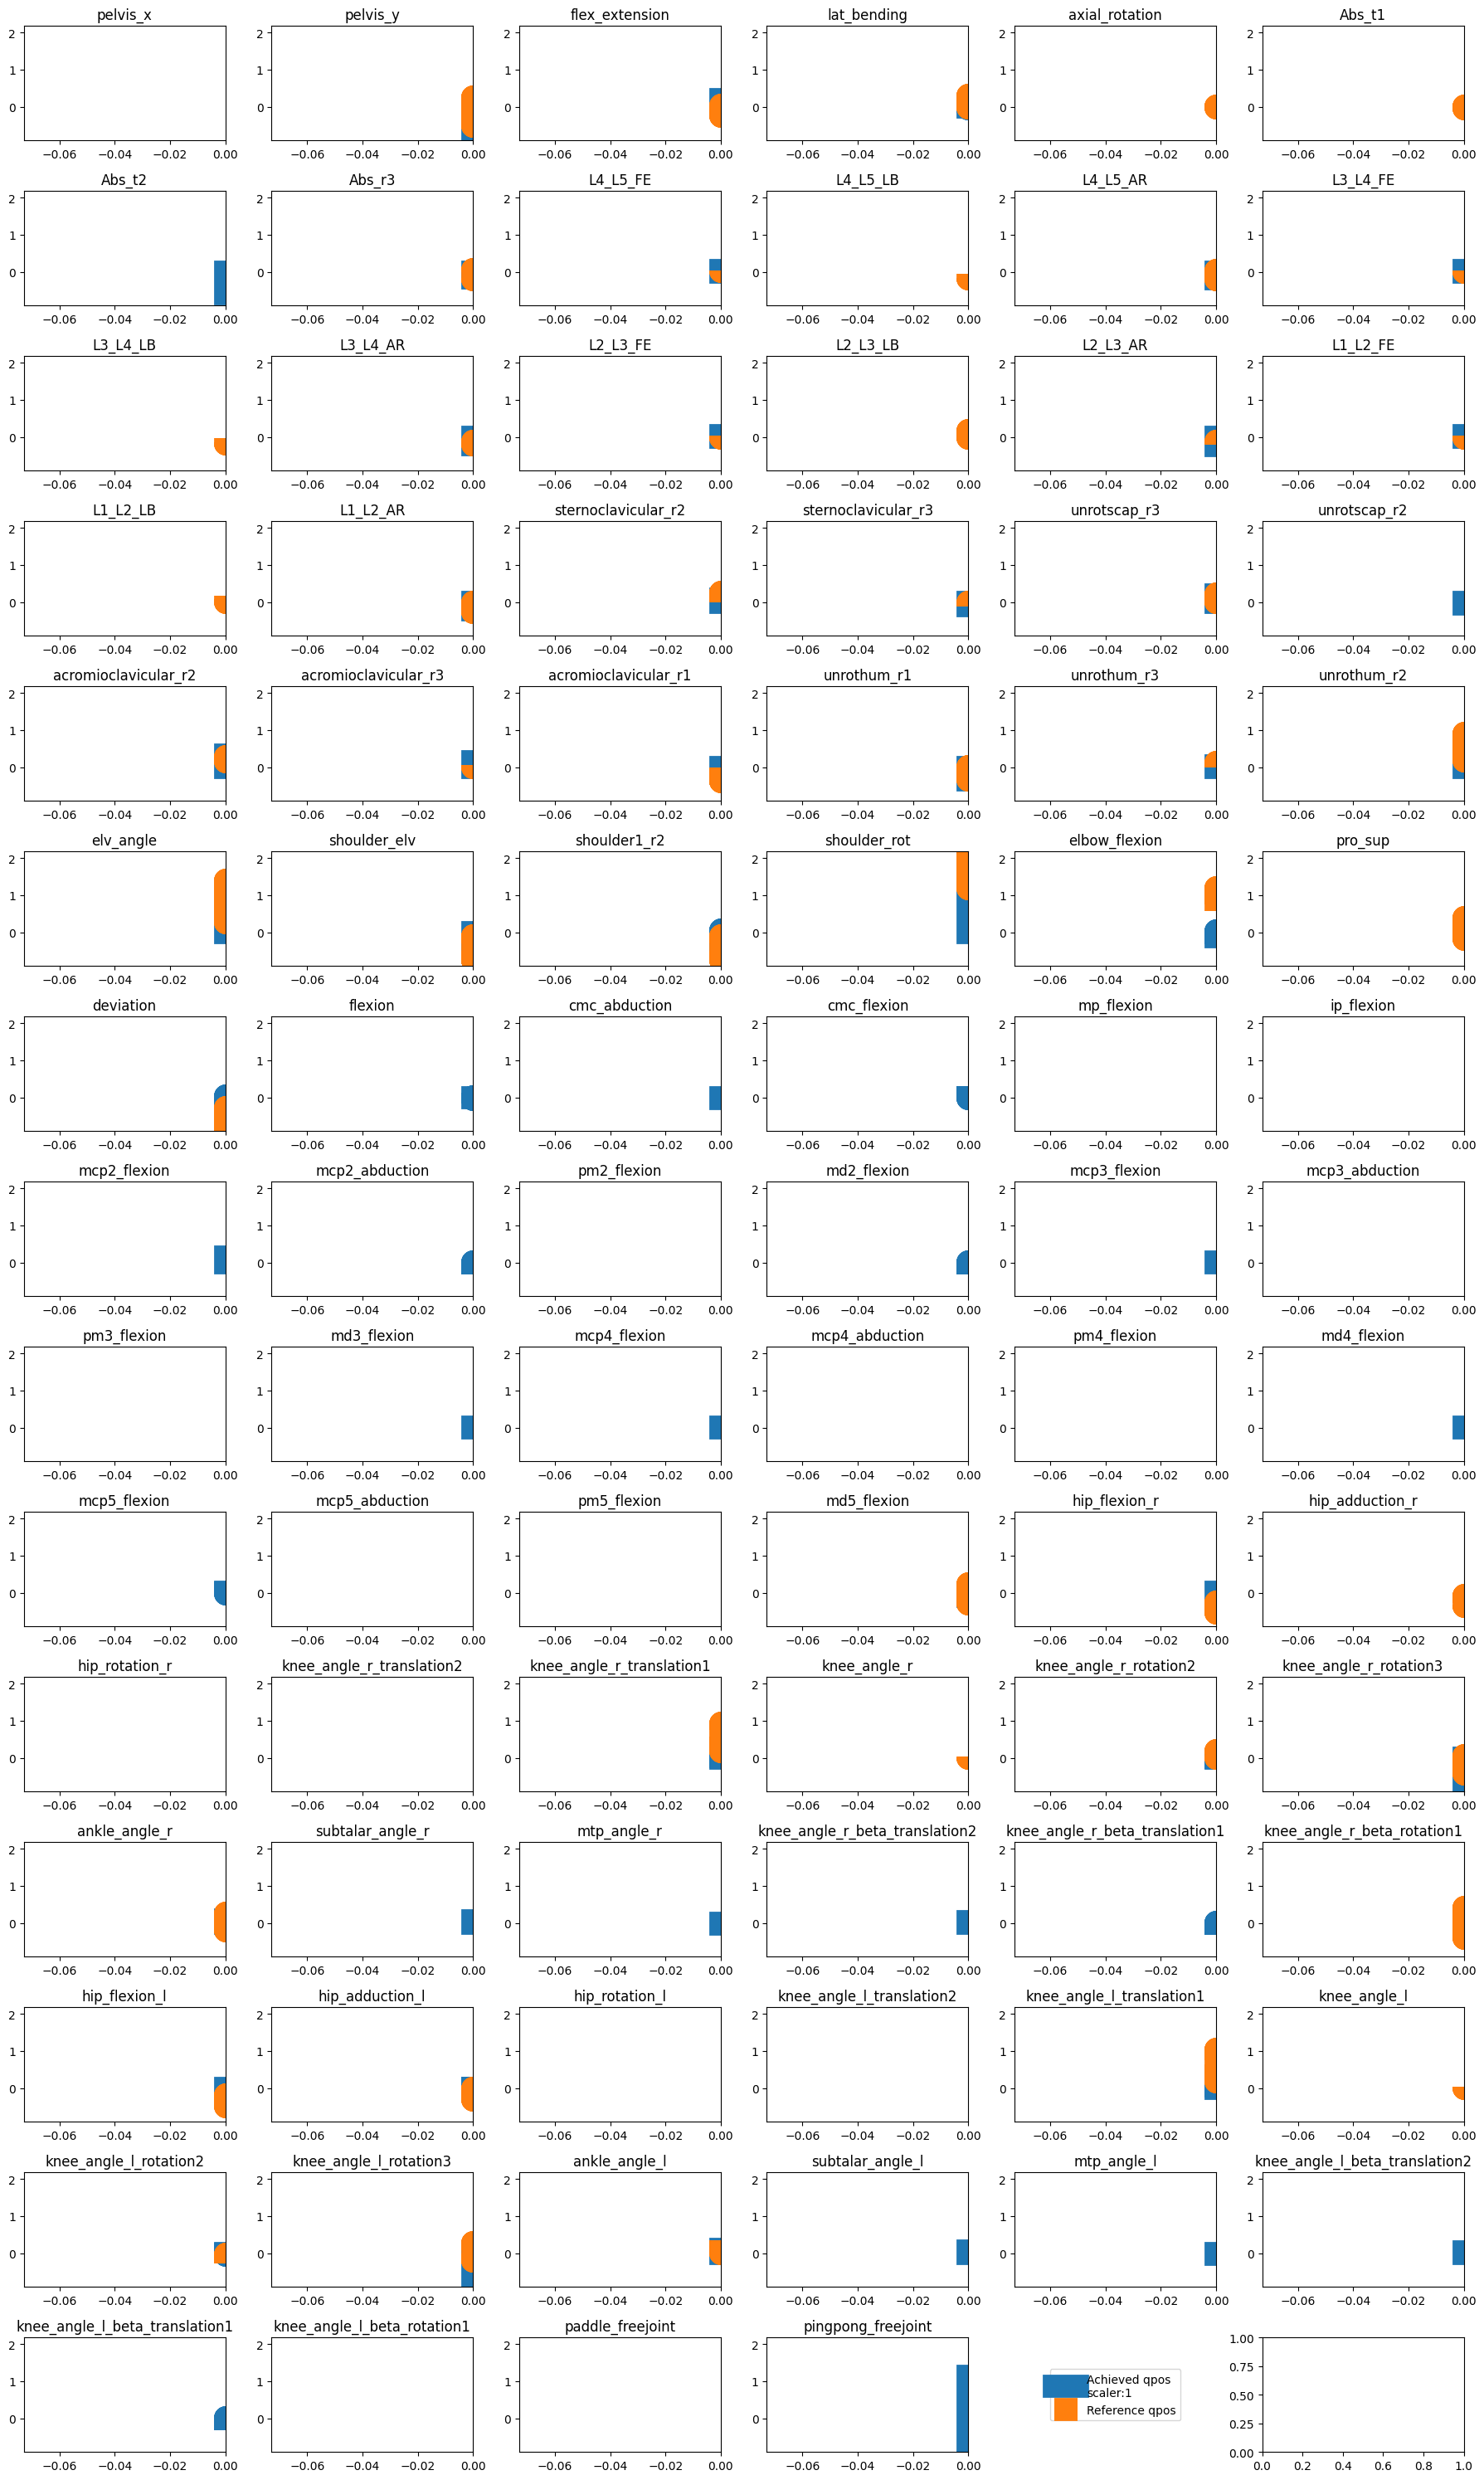

In [208]:
# ## TEST

# all_qvel_scaler = [1, 5]
# qpos_eval = np.zeros((qpos_ref.shape[0], qpos_ref.shape[1], len(all_qvel_scaler)+1))
# qpos_eval[:,:,-1] = qpos_ref
# labels_qxxx = []
# ctrl_eval = np.zeros((qpos_ref.shape[0], 1+model1.nu, len(all_qvel_scaler)))
# labels_uxxx = []
# for i_scaler, scaler in enumerate(all_qvel_scaler):
#     data1 = mujoco.MjData(model1)
#     for idx in tqdm(range(qpos_ref.shape[0])):
#         target_qpos = qpos_ref[idx]
#         qfrc = get_qfrc(model1, data1, qpos_ref[idx], qvel_ref[idx], qacc_ref[idx])
#         ctrl = get_ctrl(model1, data1, qpos_ref[idx], qvel_ref[idx], qacc_ref[idx], qfrc, 100, scaler)
#         data1.ctrl = ctrl
#         mujoco.mj_step(model1, data1)
#         qpos_eval[idx,:,i_scaler] = data1.qpos
#         ctrl_eval[idx,:,i_scaler] = np.hstack((data1.time, ctrl))
#     error = ((qpos_eval[:,:,i_scaler] - qpos_eval[:,:,-1])**2).mean(axis=0)
#     print(f'qvel scaler: {scaler} - error max (rad): {error.max()}')
#     labels_qxxx.append(f'Achieved qpos\nscaler:{scaler}')
#     labels_uxxx.append(f'Achieved ctrl\nscaler:{scaler}')
# labels_qxxx.append('Reference qpos')
# joint_names = [model1.joint(i).name for i in range(model0.njnt)]
# # plot_qxxx(qpos_eval, joint_names, labels_qxxx)
# muscle_names = [model1.actuator(i).name for i in range(model0.nu)]
# # plot_uxxx(ctrl_eval, muscle_names, labels_uxxx)